[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mertalpt/Deepgame/blob/master/DeepGame.ipynb)

This notebook is intended to run on Google Colab. For quick access either click the button above or right click and open it in a new tab if left clicking does not work.

# Welcome to DeepGame

If this is your first time working with Google Colab, check out the [introduction](https://colab.research.google.com/notebooks/intro.ipynb).

Following steps will take you through the usage and capabilities of DeepGame Cloud. We will go through loading and preprocessing media, constructings masks, applying style transfer and finally animating the result with a video.

# Setting Up

This section will walk you through getting the dependencies and setting up the workspace.

In [1]:
#@title Install and Setup Dependencies

#@markdown Note that it will ask you to authenticate your Google account by providing a link and asking for a code.
#@markdown Click the link and follow the instructions to get the code and paste it to the input field.
#@markdown It does not access your Drive contents but checks whether you have access to a shared folder.

# Necessary for matplotlib to work in GPU mode
import matplotlib
matplotlib.use('Agg')

# Suppress warnings for presentation purposes
import warnings
warnings.filterwarnings('ignore')

import os, sys, shutil

### Clone First Order Motion
if not os.path.exists('/content/first-order-model'):
  print('Cloning First Order Model...')
  !git clone --quiet https://github.com/AliaksandrSiarohin/first-order-model
  # Adding to path makes for easier imports
  sys.path.insert(1, '/content/first-order-model') 
  print('Done cloning First Order Model.')
else:
  if '/content/first-order-model' not in sys.path:
    sys.path.insert(1, '/content/first-order-model')
  print('First Order Model already exists.')

### Clone DeepGame
if not os.path.exists('/content/Deepgame'):
  print('Cloning Deepgame...')
  !git clone --quiet https://github.com/mertalpt/Deepgame.git
  # Adding to the path makes for easier imports
  sys.path.insert(2, '/content/Deepgame/deepgame-cloud')
  print('Done cloning Deepgame.')
  # Install dependencies
  print('Installing Deepgame\'s dependencies...')
  !pip install --quiet -r '/content/Deepgame/deepgame-cloud/requirements.txt'
  print('Done installing Deepgame\'s dependencies.')
else:
  if '/content/Deepgame/deepgame-cloud' not in sys.path:
    sys.path.insert(2, '/content/Deepgame/deepgame-cloud')
  print('Deepgame already exists.')

### Copy over data
data_path = '/content/data'
if not os.path.exists(data_path):
  print('Copying data from Drive.')
  from kora import drive
  folder_id = '1COKJuItmwH_GoBUTLXQiGq53OVm9PFKa'
  folder_name = drive.download_folder(folder_id)
  shutil.move('./{}'.format(folder_name), data_path)
  print('Done copying data from Drive.')
else:
  print('Drive data already exists.')

Cloning First Order Model...
Done cloning First Order Model.
Cloning Deepgame...
Done cloning Deepgame.
Installing Deepgame's dependencies...
     |████████████████████████████████| 163kB 13.9MB/s 
     |████████████████████████████████| 61kB 212kB/s 
     |████████████████████████████████| 61kB 10.4MB/s 
Done installing Deepgame's dependencies.
Copying data from Drive.
1o3T6l3VhfJT7_4551msjXItvOgyDS2wg checkpoints application/vnd.google-apps.folder (1/4)
13YwZVTANUYoAHwmQmDNhLTO7tF3k7rDq vox-adv-cpk.pth.tar application/x-tar (1/3)
Download 100%.
1-lZjY4Dcw1w4KYN4JZYEB5oPZS94HOu8 vox-adv-cpk.pth.tar application/x-tar (2/3)
100EoxITWwYZarlfygdNjxCP91gX0EOEz vox-cpk.pth.tar application/x-tar (3/3)
Download 100%.
1k_4EkMR_1EhVwusybXFJqU6_DzxTnwJQ config application/vnd.google-apps.folder (2/4)
1MuZuCamLdnQiuoHUGptCcUNKWbVE431f vox-256.yaml application/x-yaml (1/2)
Download 100%.
1yDTomSmI8ymFVcAxwN5B_vK04GVMDYDH vox-adv-256.yaml application/x-yaml (2/2)
Download 100%.
14WNk0E8iaCt3mykCCBs

In [2]:
#@title Initialize Workspace
#@markdown First run may take over 5 minutes.

#@markdown ---

#@markdown Select a model to work with:

### Initialization of ImageAnimater
config_name = 'vox-adv-256' #@param ['vox-256', 'vox-adv-256'] {type: 'string'}
config_path = '{}/config/{}.yaml'.format(data_path, config_name)
# Deduce checkpoint file from the config
if config_name == 'vox-256':
  checkpoint_name = 'vox-cpk'
elif config_name == 'vox-adv-256':
  checkpoint_name = 'vox-adv-cpk'
else:
  raise ValueError('Unrecognized config name was input.')
checkpoint_path = '{}/checkpoints/{}.pth.tar'.format(data_path, checkpoint_name)
# Initialize ImageAnimater
print('Initializing Image Animater.')
from ImageAnimater import ImageAnimater
animater = ImageAnimater(config_path, checkpoint_path)
print('Done initializing Image Animater.')

### Initialization of StyleTransferer
# Cache ML model to avoid 5-10 minutes load time
# at each rerun
print('Initializing Style Transferer.')
from StyleTransferer import StyleTransferer
if '__module' in globals():
  style_transferer = StyleTransferer(__module)
else:
  style_transferer = StyleTransferer()
  __module = style_transferer.hub_module
print('Done initializing Style Transferer.')

Initializing Image Animater.
Done initializing Image Animater.
Initializing Style Transferer.
Loading module from TF Hub. This may take 5-10 minutes.
Done initializing Style Transferer.


# Loading Images

Below are methods of loading images. You can either select from pre-existing images that comes as example data or you can load your own images via a URL or path to an image that you uploaded.

Custom image loading comes with parameters to enable focusing/restricting the image to a face in the image. Note that this face extraction does not always detect the face and may throw an error.

You can run the cells below as many times as you want. However, only the last run for each type (content/style) is kept for future processing.

Content image will be searched in /content/data/images/got-02.png.


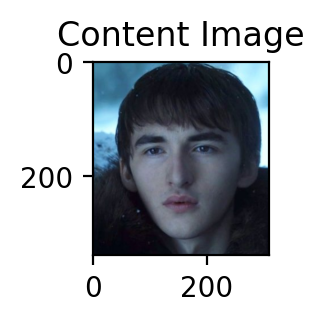

In [36]:
#@title Loading Pre-existing Content Image

import matplotlib
%matplotlib inline

#@markdown ---
#@markdown ### Select image of the person to work on:
content_image_path = 'got-02.png' #@param ['got-02.png', 'got-03.png', 'got-04.png', 'got-05.png', 'got-06.png', 'got-07.png', 'got-08.png'] {type: 'string'}
content_path = '{}/images/{}'.format(data_path, content_image_path)
print('Content image will be searched in {}.'.format(content_path))

# Load images
from DGImage import DGImage
content_image = DGImage.from_path(content_path)
DGImage.display(content_image, titles=['Content Image'])

Style image will be searched in /content/data/images/character-01.png.


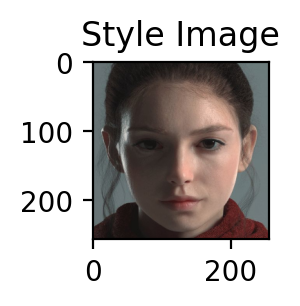

In [33]:
#@title Loading Pre-existing Style Image

import matplotlib
%matplotlib inline

#@markdown ---
#@markdown ### Select a style image to use:
style_image_path = 'character-01.png' #@param ['character-01.png', 'character-02.png'] {type: 'string'}
style_path = '{}/images/{}'.format(data_path, style_image_path)
print('Style image will be searched in {}.'.format(style_path))

# Load images
from DGImage import DGImage
style_image = DGImage.from_path(style_path)
DGImage.display(style_image, titles=['Style Image'])

Content image will be searched in https://stellaadler.com/wp-content/uploads/2017/11/Christoph-Waltz-683x1024.jpg.


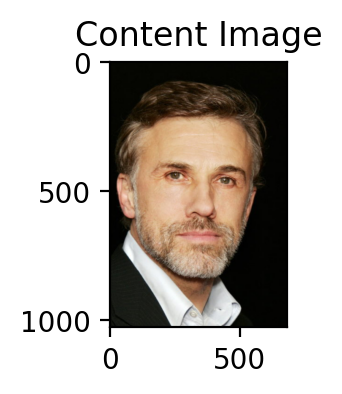

In [4]:
#@title Loading Custom Content Image

import matplotlib
%matplotlib inline

#@markdown ---
#@markdown ### Enter a path or an URL for the image of the person to work on:
content_image_locator = 'https://stellaadler.com/wp-content/uploads/2017/11/Christoph-Waltz-683x1024.jpg' #@param {type: 'string'}
print('Content image will be searched in {}.'.format(content_image_locator))

#@markdown ---
#@markdown ### Face extraction parameters:
#@markdown Go through the face extraction step?
do_extract_face = True #@param {type: 'boolean'}
#@markdown How much of the result should consist of a face, if possible? In percents.
face_percent = 30 #@param {type: 'integer'}
#@markdown Padding to leave around the face, in pixels.
padding = 0 #@param {type: 'integer'}

# Load images
from DGImage import DGImage
content_image = DGImage.from_path(content_image_locator)

if do_extract_face:
  content_image = content_image.extract_face(face_percent=face_percent, padding=padding)


DGImage.display(content_image, titles=['Content Image'])

Style image will be searched in https://steamuserimages-a.akamaihd.net/ugc/849340452687437519/3F72C13EAF6994628FEC8025CAE629A3E3A6A468/.


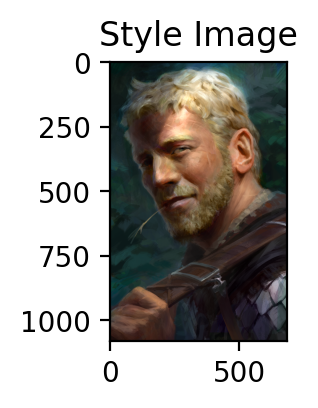

In [6]:
#@title Loading Custom Style Image

import matplotlib
%matplotlib inline

#@markdown ---
#@markdown ### Enter a path or an URL for the style image:
style_image_locator = 'https://steamuserimages-a.akamaihd.net/ugc/849340452687437519/3F72C13EAF6994628FEC8025CAE629A3E3A6A468/' #@param {type: 'string'}
print('Style image will be searched in {}.'.format(style_image_locator))

#@markdown ---
#@markdown ### Face extraction parameters:
#@markdown Go through the face extraction step?
#@markdown May not work with computer generated imagery.
do_extract_face = False #@param {type: 'boolean'}
#@markdown How much of the result should consist of a face, if possible? In percents.
face_percent = 30 #@param {type: 'integer'}
#@markdown Padding to leave around the face, in pixels.
padding = 0 #@param {type: 'integer'}

# Load images
from DGImage import DGImage
style_image = DGImage.from_path(style_image_locator)

if do_extract_face:
  style_image = style_image.extract_face(face_percent=face_percent, padding=padding)

DGImage.display(style_image, titles=['Style Image'])

# Loading the Video

You can either load a pre-existing video from the example data or you can enter the path to a video that you uploaded.

Like custom images, custom videos come with options for face extraction. If no face is detected in a frame, that frame is dropped. If all frames are dropped, it may throw an error.

In [11]:
#@title Load Pre-existing Video

#@markdown ---
#@markdown ### Select a driver video to animate images with:
video_path = '10.mp4' #@param ['00.mp4', '04.mp4', '08.mp4', '10-backward.mp4', '10.mp4'] {type: 'string'}
driver_video_path = '{}/videos/{}'.format(data_path, video_path)
print('The video will be searched in {}.'.format(driver_video_path))

# Load video
from DGVideo import DGVideo
driver_video = DGVideo.from_path(driver_video_path)

from IPython.display import HTML
driver_anim = driver_video.animation(title='Driver Video')
HTML(driver_anim.to_html5_video())

The video will be searched in /content/data/videos/10.mp4.


In [ ]:
#@title Load Custom Video from Path

#@markdown ---
#@markdown ### Enter the path to your video:
video_path = '' #@param {type: 'string'}
print('The video will be searched in {}.'.format(video_path))

#@markdown ---
#@markdown ### Face extraction parameters:
#@markdown Go through the face extraction step?
do_extract_face = True #@param {type: 'boolean'}
#@markdown How much of the result should consist of a face, if possible? In percents.
face_percent = 30 #@param {type: 'integer'}
#@markdown Padding to leave around the face, in pixels.
padding = 0 #@param {type: 'integer'}

# Load video
from DGVideo import DGVideo
driver_video = DGVideo.from_path(video_path)

if do_extract_face:
  driver_video = driver_video.extract_faces(face_percent=face_percent, padding=padding)

from IPython.display import HTML
driver_anim = driver_video.animation(title='Driver Video')
HTML(driver_anim.to_html5_video())

# Display Your Inputs

Here, you can check your current selection before moving on to the future processing steps.

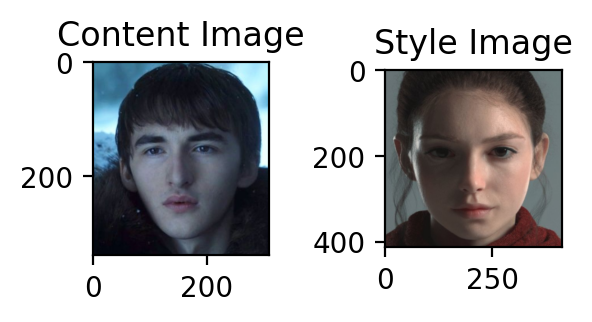

In [37]:
#@title Display Selected Images

from DGImage import DGImage
DGImage.display(content_image, style_image, titles=['Content Image', 'Style Image'])

In [13]:
#@title Display Selected Video

from IPython.display import HTML
driver_anim = driver_video.animation(title='Driver Video')
HTML(driver_anim.to_html5_video())

# Style Transfer

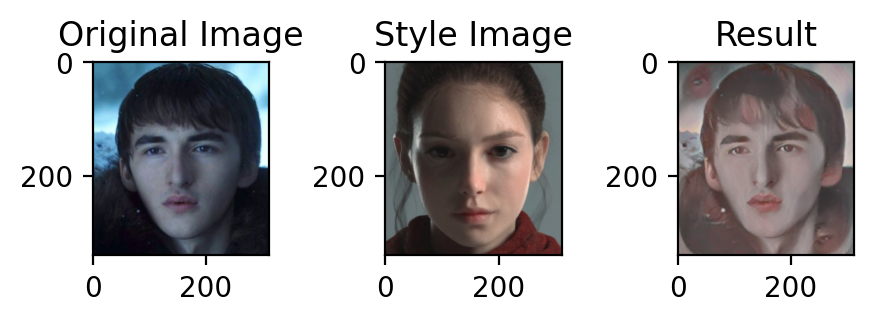

In [38]:
#@markdown ### Apply Style Transfer

styled_image = style_transferer.stylize(style_image, content_image)

# Resize the original to match the styled one
styled_shape = styled_image.shape()
content_image = content_image.resize(styled_shape[:2])
style_image = style_image.resize(styled_shape[:2])

from DGImage import DGImage
DGImage.display(content_image, style_image, styled_image, 
                titles=['Original Image', 'Style Image', 'Result'])

# Construct a Mask for the Image

Unfortunately, this step requires human intervention. You are supposed to construct a mask that covers the background of an image. We will construct the mask on the original image, then apply the mask to the result of the style transfer. Constructing the mask directly on the result may work better in some cases.

Mask pieces can be constructed automatically or manually by inputting pixels on an image and marking whether to keep them. Refer to the *MaskOperations* class source code for better understanding.

We will feature the automatic construction here. 

Afterwards, you are supposed to use set operations *union, difference and intersection* included in the *MaskOperations* class to construct a mask.

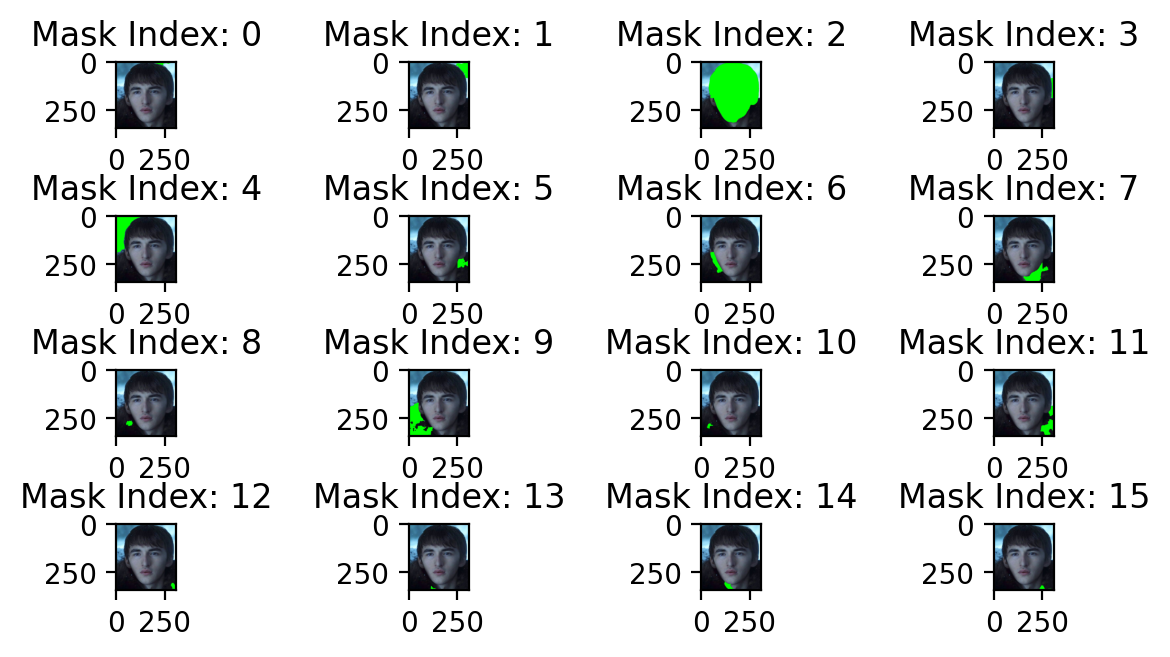

In [41]:
#@title Automatically Generate Mask Pieces

#@markdown ---

#@markdown How bright of pixels count for a segment of their own?
brightness_threshold = 0.9 #@param {type: 'slider', min: 0.0, max: 1.0, step: 0.01}

#@markdown ---

#@markdown How dark of pixels count for a segment of their own?
darkness_threshold = 0.04  #@param {type: 'slider', min: 0.0, max: 1.0, step: 0.01}

#@markdown ---

#@markdown How hard to blur edges when detecting contours?
sigma = 2 #@param {type: 'slider', min: 0.1, max: 5.0, step: 0.1}

#@markdown ---

#@markdown For which pixel count the segments should be filtered out?
size_filter = 250 #@param {type: 'integer'}

from MaskOperations import MaskOperations
masks = MaskOperations.generate(content_image,
                                light_mod=brightness_threshold,
                                dark_mod=darkness_threshold,
                                sigma=sigma,
                                size_lim=size_filter)

MaskOperations.display(content_image, masks)

Here, we apply set operations to construct the final mask. 

Do not run blindly, may not work for your inputs without changes.

Some notes about possible operations:

*    Union: Joins masks. Use 'MaskOperations.union(*masks)'.
*    Intersection: Takes common points of masks. Use 'MaskOperations.intersection(*masks)'.
*    Difference: Removes common points of two masks from the first one. Use 'MaskOperations.difference(mask_1, mask_2)'.
*    Negation: Flips the mask. Use '~mask', it is an operator that results in a flipped mask.

If you are patient, you can accumulate masks from different runs of the previous cell. That way you can fine tune your mask.

In [42]:
from MaskOperations import MaskOperations

# Final mask is expected in a variable named 'final_mask'.
final_mask = ~masks[2]

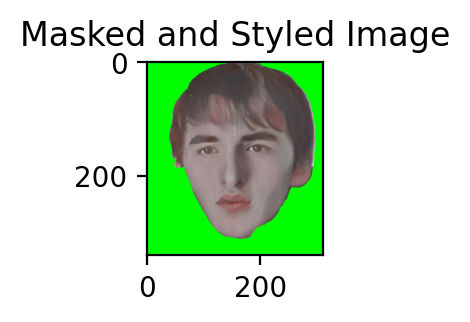

In [43]:
#@title Apply the Mask

masked_image = MaskOperations.apply(styled_image, final_mask)

from DGImage import DGImage
DGImage.display(masked_image, titles=['Masked and Styled Image'])

# Image Animation

In [44]:
#@title Animate the Result

print('Animating...')
intermediate_result = animater.animate(driver=driver_video, target=masked_image)
print('Done.')

Animating...


100%|██████████| 444/444 [00:18<00:00, 24.26it/s]


Done.


In [45]:
#@title Display the Intermediate Result

from IPython.display import HTML
animation = intermediate_result.animation(title='Intermediate Result')
HTML(animation.to_html5_video())

In [46]:
#@title Make the Mask Transparent

# Default mask color is [0, 255, 0, 255]
# Image animation may introduce small artifacts
lower_color = [0, 240, 0, 255]
upper_color = [15, 255, 15, 255]
# Make the mask a transparent white
# Since alpha is 0, rest of the color should not matter
new_color = [255, 255, 255, 0]

from DGVideo import DGVideo
animated = intermediate_result.swap_color_range(lower_color, upper_color, new_color)

In [47]:
#@title Display the Final Result

from IPython.display import HTML
animation = animated.animation(title='Final Result')
HTML(animation.to_html5_video())

In [48]:
#@title Save the Result

#@markdown ---

#@markdown Which format to save the files as?
output_format = 'Into a Directory with Frames Separated as PNG Images' #@param ['.mp4 File', 'Into a Directory with Frames Separated as PNG Images']

#@markdown ---

#@markdown Root directory to save the result in:
output_path = '/content/result' #@param {type: 'string'}

#@markdown ---

#@markdown If format is mp4, will be the file name.

#@markdown If format is frames as PNGs, will be file name prefix.
file_name = 'image-' #@param {type: 'string'}

print('Saving...')
import os
if output_format == '.mp4 File':
  result_path = '{}/{}.mp4'.format(output_path, file_name)
  if os.path.isdir(result_path):
    raise ValueError('Save path already exists as a directory.')
  animated.save(result_path)
else:
  if not os.path.exists(output_path):
    os.mkdir(output_path)
  elif os.path.isfile(output_path):
    raiseValueError('Save path already exists as a file.')
  animated.save_to_directory(output_path, prefix=file_name)

print('Done saving.')

Saving...
Done saving.


# Conclusion

Afterwards, you can download the mp4 file through Colab.

If you opted for frames as PNGs format, you can use the '!zip -r /path/to/output' command to zip the directory and download the zip itself. Find the example stub below.

In [ ]:
!zip -r /path/to/output